![CAT_DOG](img/cat_dog.jpeg)

# Classifier des images de chiens et de chats avec un MLP

🎯 **Objectif du projet**

Vous devez concevoir, entraîner et évaluer un réseau de neurones de type MLP (Multilayer Perceptron) capable de distinguer des images de chiens et de chats. Ce projet vous permettra de comprendre les bases de la classification supervisée appliquée aux images, en utilisant une architecture dense simple.  

Les images des animaux se trouvent dans `data/pets`.

📝 **Recommandations techniques**
> Taille des images :
- Redimensionnez toutes les images à une taille uniforme, par exemple 64×64 pixels.
- Pour faciliter cet exercice, travaillez avec des images en niveau de gris. 
- Chaque image devra être aplatie (flatten) en un vecteur d’entrée de 4096 valeurs (64×64).
> Architecture du MLP :
- Utilisez 1 à 3 couches cachées avec des activations ReLU. Vous pouvez expérimenter d'autres fonction d'activations.
- La dernière couche doit comporter 1 seul neurone avec une activation sigmoid, car vous êtes sur une tâche de classification binaire.
> Fonction de perte :
- Utilisez impérativement la fonction binary_crossentropy, adaptée à une sortie de type sigmoid.
> Évaluation du modèle :
- Affichez la précision (accuracy) sur l’ensemble d’entraînement et de validation.
- tilisez une matrice de confusion pour analyser les erreurs.
> Prétraitement des données :
- Appliquez une normalisation des pixels (ex. : rescale=1./255) pour faciliter l’apprentissage du modèle.
> Bonnes pratiques :
- Travaillez avec un générateur d’images pour éviter de charger tout en mémoire.
- Séparez bien vos données en train / validation.
> Bonus
- Travaillez avec un générateur d’images pour éviter de charger tout en mémoire : ImageDataGenerator

In [1]:
# Import des dépendances 

import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

np.set_printoptions(linewidth=np.inf)
np.set_printoptions(edgeitems=30) 

2025-05-20 23:59:41.684099: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-20 23:59:41.686945: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-20 23:59:41.694343: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747778381.706048   17603 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747778381.709498   17603 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747778381.720099   17603 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

[[ 39  40  41  41  41  41  41  40  63  50  37  36  48  56  51  41  38  32  45  58  48  40  40  37  46  28  57  40  33  38 ...  97  90  80  69  64  75  96 105  98  85  82  84  93  94  88  93  93  77  91  88  89  99 103 149 155 181 196 194 194 197]
 [ 41  42  42  43  43  43  42  42  68  56  41  37  45  54  52  44  46  41  42  51  34  40  42  42  42  37  50  37  54  43 ...  94  86  76  77  71  70  86 103  93  70  87  89 100 100  92  95  95  81  86  94  95  93  97 154 163 181 202 199 197 198]
 [ 44  44  44  44  44  44  44  44  65  57  42  33  37  45  46  40  39  42  37  49  25  45  42  41  39  46  44  34  70  53 ...  89  83  71  80  75  65  78 101  92  64  85  90 103 106  95  94  94  82  79  98 100  89  92 159 169 181 200 197 193 191]
 [ 45  44  43  43  42  42  43  43  60  58  48  36  34  41  41  35  29  40  39  58  32  56  46  41  41  45  42  32  60  63 ...  84  85  71  76  71  66  78  96  95  80  75  82 101 109  98  93  91  79  76  92  96  92  96 157 166 181 195 194 192 190]
 [ 43  42  4

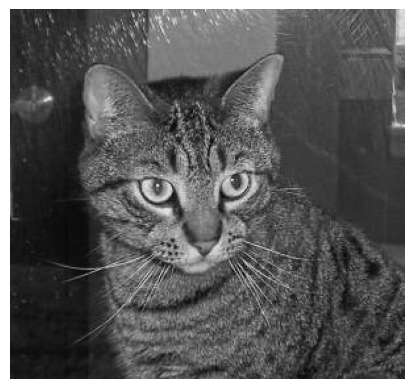

Shape (dimensions)    : (281, 300)
Type des valeurs      : uint8


In [2]:
# On charge une image depuis un chemin local, l’image est chargé en 1 canal (valeur de pixel de 0 à 255)
img = cv2.imread("data/pets/train/cat/1.jpg", cv2.IMREAD_GRAYSCALE)

# Observer l'image sous forme de matrice
print(img)

# Visualisation de l'image
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.show()

# Inspection des métadonnées de l'image
print(f"Shape (dimensions)    : {img.shape}")
print(f"Type des valeurs      : {img.dtype}")

# Préparation des données 

In [3]:
def get_train_test(base_path: str, img_size=(64, 64)):
    X = []  # liste pour stocker les images
    y = []  # liste pour stocker les étiquettes correspondantes

    # Dictionnaire pour mapper les étiquettes de chaînes à des entiers
    label_map = {'cat': 0, 'dog': 1}

    # On parcourt les sous-dossiers du répertoire
    for label in sorted(os.listdir(base_path)):
        # On ignore les fichiers qui ne sont pas des dossiers de classes
        if label not in label_map:
            continue
        label_path = os.path.join(base_path, label)

        # On parcourt chaque image du dossier
        for file_name in os.listdir(label_path):
            file_path = os.path.join(label_path, file_name)
            # Lecture de l'image en niveaux de gris
            img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue  # image illisible, on passe
            
            # Redimensionnement de l'image
            img = cv2.resize(img, img_size)  # Redimensionner à 64x64 pixels
            X.append(img)           # on ajoute l'image à la liste
            y.append(label_map[label])  # on ajoute le label numérique

    # Conversion des listes en tableaux NumPy
    X = np.array(X)
    y = np.array(y)
    return X, y

X_train, y_train = get_train_test("data/pets/train")
X_test, y_test = get_train_test("data/pets/test")

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9


## Vérification des données 

In [ ]:
# Vérification des données préparées
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(X_train[i], cmap="grey")
    plt.axis("off")

plt.show()

# Preprocessing 

In [4]:
# Les images sont au format (28, 28). On les convertit en float pour normaliser ensuite
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

# Normalisation : on divise les valeurs de pixels par 255 pour les ramener entre 0 et 1
X_train /= 255.0
X_test /= 255.0

# Flatten : pour un MLP, chaque image 28x28 doit devenir un vecteur de 784 valeurs
X_train = X_train.reshape(X_train.shape[0], 64 * 64)
X_test = X_test.reshape(X_test.shape[0], 64 * 64)

# Créer un générateur d'images avec normalisation
datagen = ImageDataGenerator(
    rescale=1./255,  # Normalisation des pixels
    rotation_range=20,  # Exemple d'augmentation : rotation
    width_shift_range=0.2,  # Décalage horizontal
    height_shift_range=0.2,  # Décalage vertical
    shear_range=0.2,  # Cisaillement
    zoom_range=0.2,  # Zoom
    horizontal_flip=True,  # Retourner horizontalement
    fill_mode='nearest'  # Mode de remplissage
)
 # Créer un générateur pour les données d'entraînement
train_generator = datagen.flow(X_train.reshape(-1, 64, 64, 1), y_train, batch_size=32)

# Créer un générateur pour les données de test (sans augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow(X_test.reshape(-1, 64, 64, 1), y_test, batch_size=32) 



# Générer un lot d'images
#images, labels = next(train_generator)

# # Visualiser les images
# plt.figure(figsize=(10, 10))
# for i in range(5):  # Afficher 5 images
#     plt.subplot(1, 5, i + 1)
#     plt.imshow(images[i].reshape(64, 64), cmap='gray')  # Afficher l'image
#     plt.title(f'Label: {labels[i]}')  # Afficher l'étiquette
#     plt.axis('off')  # Ne pas afficher les axes
# plt.show()


In [ ]:
# Définir le modèle
model = models.Sequential([
    layers.Input(shape=(64, 64, 1)),  # Couche d'entrée : image de 64x64 pixels en niveaux de gris

    # 1ère couche convolutive
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),  # Normalisation par lots
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    # 2e couche convolutive
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    # 3e couche convolutive
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Flatten(),  # Aplatir les sorties pour les couches denses
    
    # Couches denses
    layers.Dense(4096, activation='relu'),  # Couche dense avec 4096 neurones
    layers.Dropout(0.5),  # Dropout pour réduire le surapprentissage
    
    layers.Dense(2, activation='softmax')  # Couche de sortie : 2 classes (chat et chien)
])

# Compilation du modèle
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Afficher le résumé du modèle
model.summary()

In [ ]:
# Définir le modèle
model = models.Sequential([
    layers.Input(shape=(4096,)),  # Couche d'entrée : vecteur de 4096 éléments

    # Couche dense initiale pour transformer l'entrée
    layers.Dense(512, activation='relu'),  # Couche dense pour réduire la dimensionnalité
    layers.Dropout(0.5),  # Dropout pour réduire le surapprentissage

    # 1ère couche convolutive (si vous souhaitez toujours utiliser des convolutions)
    layers.Reshape((64, 64, 1)),  # Reshape pour passer à une forme d'image
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    # 2e couche convolutive
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    # 3e couche convolutive
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Flatten(),  # Aplatir les sorties pour les couches denses
    
    # Couches denses
    layers.Dense(4096, activation='relu'),  # Couche dense avec 4096 neurones
    layers.Dropout(0.5),  # Dropout pour réduire le surapprentissage
    
    layers.Dense(2, activation='softmax')  # Couche de sortie : 2 classes (chat et chien)
])

# Compilation du modèle
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Afficher le résumé du modèle
model.summary()

In [ ]:
# Entraînement du modèle
model.fit(train_generator, validation_data=test_generator, epochs=10)